# HTREC 2022

## Sign in
* To get the data.

In [ ]:
%%capture
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/lBhMkZgkm57hVw89rEmivEL14CEEeuajU9lPLMVXgfM
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c htrec-2022 -o data

official_ranking.csv:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

original_test.csv:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

synthetic_test.csv:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/45.5k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/395k [00:00<?, ?B/s]

In [ ]:
%%capture
!pip install pywer
import pywer
import pandas as pd
import numpy as np
import os

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
print(f"{train_df.shape[0]} train and {test_df.shape[0]} instances"); train_df.sample()

1875 train and 338 instances


,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM
1781,τε επηγαγεν και διεχωρησεν ο θς αναμεσον,τε επηγαγεν ουὐδιεχωρησενοθες αναμεσον,10,96 Bodleian-Library-MS-Barocci-184_00036_fol-1...,23


# Exploratory Data Analysis (EDA)

In [ ]:
print(train_df.shape)
train_df.head(5)

(1875, 5)


,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM
0,ἐγγινομένα πάθη μὴ σβεννύντες ἀλλὰ τῆ εκλύσει,ἐγγενομεναπαδημησμεννωτες ἀλλατῆε κλησει,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,1
1,τοῦ βίου τοῦ καθ ΄ εαυτοὺς πολλὰ γίνεσθαι συγχ...,του β ου του καλεαυτοὺς πολλαγινεσθαι συγχωρ όν,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,2
2,τες ἐμπυρίζουσι τὸν ἀμπελῶνα ἀλλὰ καὶ ὁ διὰ,τες εμπυριζου σιμαμπελῶνα ἀλλακαι ὅδξα,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,3
3,τῆς ἡδεῖας πλεονεξίας πολλοὺς εἰς τὴν τῶν ἀλλ,της ἐδίας πλσον ἐξιας πολλους ἐις τὴν τῶν ἀλ,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,4
4,οτρίων ἐπιθυμίαν προκαλούμενος ἐμπυρί,λοτρλων ἐπιθυμιαν προκαλουμένος ἐμπυρι,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,5


In [ ]:
print(test_df.shape)
test_df.head(1)

(338, 4)


,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM
0,ὑπρ τη συνευςδιξοεανδνυπορ ποοδυπρας,14,66 Bodleian-Library-MS-Barocci-127_00136_fol-66v,1


**Notes:** ἀλλατῆε κλησει	-> ἀλλὰ τῆ εκλύσει

**Problems:**

1) Concat words and characters (eg ἀλλατῆε κλησει-> ἀλλὰ τῆ εκλύσει)

2) Confuse similar characters (eg σμεννωτες -> σβεννύντες)

3) Not recognize circumflex/punctuations (eg τῆς -> της) 

4) but are the other and other of Friday the milk (eg οτρίων -> λοτρλων)

5) Not recognize characters (eg βίου -> β ου)

6) Noisy gold  (eg. (id3) τῶν ἀλλ, (id4)οτρίων
-> ἀλλοτρίων )


**Preprocessing Rule base:**

και-> μονα τους

ς -> χωρισζουμε λεξη

το,τη,των-> μονα τους

In [ ]:
ht_raw = " ".join(train_df.HUMAN_TRANSCRIPTION.to_list())
st_raw = " ".join(train_df.SYSTEM_TRANSCRIPTION.to_list())
print(f"{len(set(ht_raw.lower()))} characters in human transcription")
print(f"{len(set(st_raw.lower()))} characters in system transcription")
print(f"The following characters have not been system-transcribed: \n{set(ht_raw.lower())-set(st_raw.lower())}")
print(f"The following *have been* system-transcribed: \n{set(ht_raw.lower()).intersection(set(st_raw.lower()))}")

131 characters in human transcription
77 characters in system transcription
The following characters have not been system-transcribed: 
{'ὗ', 'ᾗ', ';', 'ἧ', 'έ', ';', 'ἄ', 'ᾑ', 'ΐ', 'ῥ', 'ἃ', 'ὦ', "'", 'ή', 'ὖ', 'ἷ', 'ύ', '΄', 'ὣ', 'ἅ', 'ὕ', 'ᾧ', 'ἣ', 'ἥ', 'ὠ', 'ὧ', 'ἇ', 'ώ', 'ῤ', 'ᾔ', 'ᾠ', 'ά', 'ἦ', 'ἳ', 'ᾦ', 'ᾷ', 'ὔ', 'ὀ', 'ὤ', 'ὄ', 'ὓ', 'ί', 'ῒ', 'ῄ', 'ῇ', 'ᾴ', '᾿', 'ὃ', 'ᾄ', 'ᾶ', 'ᾅ', 'ϊ', 'ᾤ', 'ἂ'}
The following *have been* system-transcribed: 
{'ω', 'ὡ', 'ά', 'ζ', 'ὺ', 'ε', 'ς', 'ἤ', '.', 'ό', 'π', 'ο', 'μ', 'ἱ', 'ί', 'γ', 'ύ', 'ό', ',', 'ἁ', 'έ', 'ἠ', 'ι', 'ή', 'κ', 'η', 'ἡ', '᾽', 'ἶ', 'ὰ', 'ν', 'ῦ', 'ὁ', 'ὅ', 'θ', 'ἕ', 'ὴ', 'ὶ', 'ῃ', 'ἀ', 'δ', 'ἐ', 'ἔ', 'ῳ', 'ἴ', 'ὑ', 'ὐ', 'ῶ', 'ἢ', 'ἰ', 'ρ', 'ὲ', 'β', 'ῴ', '·', 'σ', 'ῷ', 'λ', 'ὸ', 'φ', 'ᾳ', 'ὥ', 'ἑ', 'τ', 'α', 'ψ', 'ῖ', 'ὼ', 'ῆ', 'ὢ', 'ξ', '·', 'χ', ' ', 'ἵ', 'υ', 'ώ'}


In [ ]:
tokens = ht_raw.split()
WORDS = set(tokens) # set include unique values

In [ ]:
print(f"Number of strings: {len(tokens)}")
print(f"Number of unique strings: {len(set(tokens))}")

Number of strings: 12797
Number of unique strings: 6210


#### Frequently mistaken tokens 

In [ ]:
LEX = train_df.HUMAN_TRANSCRIPTION.sum().split()

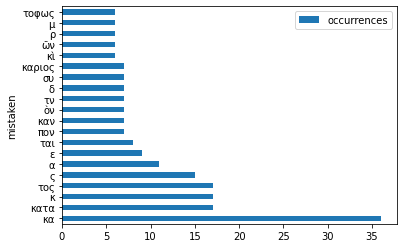

In [ ]:
from collections import Counter
broken_words = [w for w in train_df.SYSTEM_TRANSCRIPTION.sum().split() if w not in set(LEX)]
x,y = zip(*Counter(broken_words).most_common(20))
pd.DataFrame({"mistaken":x, "occurrences":y}).plot.barh(x="mistaken");

#### Frequent based on all 

In [ ]:
# Prepare training corpus into one giant string
train_string = " ".join(train_df.SYSTEM_TRANSCRIPTION)
print(f"***** Extract of a train string ***** \n{train_string[:200]}", "\n")

annot_string = " ".join(train_df.HUMAN_TRANSCRIPTION)
print(f"***** Extract of a human annotation string ***** \n{annot_string[:200]}", "\n")

***** Extract of a train string ***** 
ἐγγενομεναπαδημησμεννωτες ἀλλατῆε κλησει του β ου του καλεαυτοὺς πολλαγινεσθαι συγχωρ όν τες εμπυριζου σιμαμπελῶνα ἀλλακαι ὅδξα της ἐδίας πλσον ἐξιας πολλους ἐις τὴν τῶν ἀλ λοτρλων ἐπιθυμιαν προκαλουμ 

***** Extract of a human annotation string ***** 
ἐγγινομένα πάθη μὴ σβεννύντες ἀλλὰ τῆ εκλύσει τοῦ βίου τοῦ καθ ΄ εαυτοὺς πολλὰ γίνεσθαι συγχωροῦν τες ἐμπυρίζουσι τὸν ἀμπελῶνα ἀλλὰ καὶ ὁ διὰ τῆς ἡδεῖας πλεονεξίας πολλοὺς εἰς τὴν τῶν ἀλλ οτρίων ἐπιθυ 



In [ ]:
# Split train_corpus by white space
splits = train_string.split()  
print(f"***** Extract of splits ***** \n{splits[:20]}\n")

splits_annot = annot_string.split() 

***** Extract of splits ***** 
['ἐγγενομεναπαδημησμεννωτες', 'ἀλλατῆε', 'κλησει', 'του', 'β', 'ου', 'του', 'καλεαυτοὺς', 'πολλαγινεσθαι', 'συγχωρ', 'όν', 'τες', 'εμπυριζου', 'σιμαμπελῶνα', 'ἀλλακαι', 'ὅδξα', 'της', 'ἐδίας', 'πλσον', 'ἐξιας']



In [ ]:
print(f"Number of strings in train: {len(splits)}")
print(f"Number of unique strings in train: {len(set(splits))}")
print('vs')
print(f"Number of strings in annot: {len(splits_annot)}")
print(f"Number of unique strings in annot: {len(set(splits_annot))}")

Number of strings in train: 11042
Number of unique strings in train: 7206
vs
Number of strings in annot: 12797
Number of unique strings in annot: 6210


In [ ]:
# import pickle
# ##To save in file
# with open('annot_corpus.txt','wb') as f:
#    pickle.dump(set(splits_annot), f)

In [ ]:
# ##To read it again from file
# with open('annot_corpus.txt','rb') as f:
#    my_set = pickle.load(f)

There are approximately 11.000 strings in the training corpus with around 7.200 unique strings. However, we do not take extra information as the annotation dataset has the same distribution 

In [ ]:
import nltk
from nltk import FreqDist

#frequency distribution for each string
freq_splits = FreqDist(splits)
print(f"***** 10 most common strings train ***** \n{freq_splits.most_common(10)}", "\n")

#frequency distribution for each string
freq_splits_annot = FreqDist(splits_annot)
print(f"***** 10 most common strings annotation***** \n{freq_splits_annot.most_common(10)}", "\n")

***** 10 most common strings train ***** 
[('και', 168), ('καὶ', 157), ('του', 100), ('τὴν', 98), ('την', 88), ('τα', 78), ('τῶν', 77), ('τοῦ', 75), ('τὸν', 74), ('τῆς', 62)] 

***** 10 most common strings annotation***** 
[('καὶ', 300), ('και', 299), ('το', 110), ('τὴν', 105), ('δὲ', 95), ('τοῦ', 94), ('τῶν', 93), ('του', 92), ('τῆς', 90), ('ἐν', 90)] 



We may have problem with 'καὶ', because neither annotators use the same emphasis (('καὶ', 300), ('και', 299)). However, it is more clear for 'τὴν'. 

Moreover, it is obvious that the most common strings are stop words

In [ ]:
m = train_df[['HUMAN_TRANSCRIPTION']].apply(lambda x: x.str.contains('και')).any(1)
train_df[m][["HUMAN_TRANSCRIPTION","SYSTEM_TRANSCRIPTION"]].head()

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION
7,δικον κτῆσιν και ἀπὸ ἀρπαγῆς καὶ βίας συλλεγόντες,ικον κτῆσιν αποαρπαγης καιβωας συγεγοντεσ
20,μου και το προσωπον των πτωχων καταισχυνετε,"μος, καὶ τοπρο ποτω απτω χω ηκατίςχων ερ"
21,εθος τοις αδικουσι και αποστερουσιν επειδαν,θος τοις ἀδεκου σικαιἀπόστερου σίη επειδαν
22,εγκαλωνται παρα των ηδικημενων υβρεσι και λοι,ἐγκαλων τα παρατων ηδικήμενων χβρεσικατ
23,δοριαις καταισχυνειν αυτους εξευτελιζοντες και,δορίαι εκαται εχν εν αυτοὺς ἐξευὑτελύζον τεσκαι


In [ ]:
# we find all the words that have less than 4 characters (small words)
short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short

[('και', 168),
 ('καὶ', 157),
 ('του', 100),
 ('τὴν', 98),
 ('την', 88),
 ('τα', 78),
 ('τῶν', 77),
 ('τοῦ', 75),
 ('τὸν', 74),
 ('τῆς', 62),
 ('δὲ', 59),
 ('το', 53),
 ('τον', 53),
 ('των', 49),
 ('κα', 45),
 ('τ', 43),
 ('α', 42),
 ('δια', 36),
 ('οὐ', 36),
 ('ε', 36),
 ('κ', 34),
 ('ην', 34),
 ('η', 34),
 ('της', 34),
 ('εν', 32),
 ('ἐν', 29),
 ('δε', 29),
 ('ότι', 29),
 ('εις', 28),
 ('ὁ', 28),
 ('ον', 28),
 ('ς', 28),
 ('ο', 27),
 ('τας', 26),
 ('προ', 24),
 ('ν', 24),
 ('τ᾽', 24),
 ('τε', 24),
 ('τος', 22),
 ('μη', 22),
 ('ου', 22),
 ('τω', 21),
 ('γαρ', 19),
 ('τῷ', 19),
 ('τη', 19),
 ('καί', 19),
 ('αν', 18),
 ('τις', 17),
 ('ως', 17),
 ('μεν', 17),
 ('θυ', 14),
 ('ται', 13),
 ('οι', 13),
 ('ει', 13),
 ('ὡς', 12),
 ('τι', 12),
 ('τν', 12),
 ('ος', 11),
 ('επι', 11),
 ('γὰρ', 11),
 ('ω', 10),
 ('κὶ', 10),
 ('μον', 10),
 ('πον', 10),
 ('δ', 10),
 ('πρ', 10),
 ('ὥς', 10),
 ('ἢ', 10),
 ('ρ', 9),
 ('ὸν', 9),
 ('μου', 8),
 ('αὐ', 8),
 ('ουν', 8),
 ('πνα', 8),
 ('εκ', 8),
 ('ῶν', 8),


In [ ]:
# we find all the words that have less than 4 characters (small words) for the annotated strings
short = set(s for s in splits_annot if len(s)<4)
short = [(s, freq_splits_annot[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short

[('καὶ', 300),
 ('και', 299),
 ('το', 110),
 ('τὴν', 105),
 ('δὲ', 95),
 ('τοῦ', 94),
 ('τῶν', 93),
 ('του', 92),
 ('ἐν', 90),
 ('τῆς', 90),
 ('ὁ', 81),
 ('την', 80),
 ('γὰρ', 77),
 ('των', 68),
 ('καί', 68),
 ('ο', 67),
 ('τὸν', 67),
 ('ὡς', 66),
 ('της', 66),
 ('τῷ', 57),
 ('τα', 53),
 ('δε', 48),
 ('εν', 43),
 ('γαρ', 42),
 ('τον', 41),
 ('τὸ', 38),
 ('τι', 38),
 ('ἢ', 38),
 ('δ᾽', 37),
 ('ὦ', 37),
 ('τὰ', 36),
 ('μὲν', 36),
 ('εἰς', 36),
 ('μη', 34),
 ('μὴ', 34),
 ('η', 33),
 ('οὐ', 32),
 ('τε', 32),
 ('τόν', 31),
 ('τῇ', 31),
 ('οὐκ', 31),
 ('τήν', 29),
 ('τω', 27),
 ('τη', 27),
 ('τὰς', 27),
 ('εις', 25),
 ('ότι', 24),
 ('ου', 24),
 ('μοι', 23),
 ('ἡ', 23),
 ('τί', 23),
 ('με', 23),
 ('ἐκ', 22),
 ('προ', 21),
 ('ἂν', 21),
 ('δια', 20),
 ('θς', 20),
 ('αν', 20),
 ('δέ', 19),
 ('ἐγὼ', 19),
 ('διά', 19),
 ('σε', 19),
 ('Καὶ', 18),
 ('διὰ', 18),
 ('μου', 17),
 ('τις', 17),
 ('τό', 17),
 ('οι', 17),
 ('σὺ', 17),
 ('εἰ', 16),
 ('ως', 16),
 ('ην', 16),
 ('φως', 16),
 ('οὖν', 15),
 ('μεν

In [ ]:
# we find all the words that have more than 15 characters (longest words)
long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long

[('ελουσινύάτεοήμεραί', 1),
 ('θεγαρουκεστικαθυμων', 1),
 ('ἐγριεκεταθαιαταταεθεί', 1),
 ('τωσανωσκνεσπεριερ', 1),
 ('εντευθενδεξαμενο', 1),
 ('τενειτοτόξοηαὐτὸν', 1),
 ('τιλητιτωρονειοθε', 1),
 ('εννευμασιηοφθαλμων', 1),
 ('γενεσθαισοιραδιον·', 1),
 ('πνικοιςνοήμβασιλα', 1),
 ('λληατοητειγιήςαὐτοῦ', 1),
 ('εριαρόμένονςτηναβομιαη', 1),
 ('στρωμααβρωμεετασδι', 1),
 ('επολλμτελοίαμειπ', 1),
 ('μεληεπιτετηδευμενον', 1),
 ('κεφορανταινομενα', 1),
 ('ελευσθησανγυμνθηβ', 1),
 ('ἐγγενομεναπαδημησμεννωτες', 1),
 ('καχωνοσιξυτίαιεκς', 1),
 ('ευπεραίξωσηηξαυτας', 1),
 ('λεγονυπερβαινουσανλογωμο', 1),
 ('μικροπρεπηνομυθε', 1),
 ('παυσορεποναυτοδς', 1),
 ('ηκβομφαιαἐητοιςχειλεειήα', 1),
 ('οὐκακὅλουθείημεν', 1),
 ('ξῷιακεχωιακχειακχωδαἡχου', 1),
 ('παρασκευαζευφωταωοι', 1),
 ('ἀβομίαηκεὲχανἀρωνο', 1),
 ('ἡδεραμνοςαἀκανθαβεν', 1),
 ('πορεύθηξακτοψηλωτρ', 1),
 ('ἀφελεικετηηδοξαητε', 1),
 ('γαρπυριαλισθησεται', 1),
 ('οσυφανερωθησεται', 1),
 ('παρορανουκανεχωμενην', 1),
 ('ἔγωδρομαίονὁρμης', 1),
 ('ρ

In [ ]:
# we find all the words that have more than 15 characters (longest words) for the annotated strings
long = set(s for s in splits_annot if len(s)>15)
long = [(s, freq_splits_annot[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long

[('ἀλλοιωθησομένοις.', 2),
 ('περιόψομἀπελθόντ᾽,', 1),
 ('καταδωροδοκεῖται,', 1),
 ('ἀνταναιρεθήσονται,', 1),
 ('ἀλλοιωθησομένοις,', 1),
 ('διασκορπισθήσονται', 1),
 ('προκατειλημμενοι', 1),
 ('Ἡρακλειοξανθίαν,', 1),
 ('προσκολληθησεται', 1),
 ('κατεσχηματισμενον', 1),
 ('προστεταγμένοις,', 1),
 ('ενεπιδεικνυμενοι', 1)]

In [ ]:
# we find all the words that have more than 10 characters (longest words) for the annotated strings
long = set(s for s in splits_annot if len(s)>10)
long = [(s, freq_splits_annot[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long

[('ακατασκευαστος', 4),
 ('ἀποφθέγξονται', 3),
 ('ἡρμήνευσεν.', 3),
 ('πνευματικῆς', 3),
 ('συντελείας,', 2),
 ('ἀλλοιωθησομένοις.', 2),
 ('προσταγματι', 2),
 ('ἀναμάρτητον', 2),
 ('Διασκόρπισον', 2),
 ('καταισχυνετε', 2),
 ('εξευτελιζοντες', 2),
 ('ἀναλλοίωτον', 2),
 ('προσβλέπειν', 2),
 ('δημιουργιαν', 2),
 ('διδασκαλιαν', 2),
 ('συγκαταβασει', 2),
 ('φιλανθρωπίας', 2),
 ('ενδεικνυμενους', 2),
 ('ἡρμήνευσεν·', 2),
 ('αλισθησεται', 2),
 ('οἰκουμένην,', 2),
 ('προσαρκέσαι', 1),
 ('περιφερουσιν', 1),
 ('ματαιότητα.', 1),
 ('Ἀναστάτωσον', 1),
 ('ευκαλινδουνται', 1),
 ('μεταστησωμεν', 1),
 ('προσέπεσεν;', 1),
 ('προφέροντες·', 1),
 ('ἐσκεδασμένοι,', 1),
 ('κεχειροτονημένῳ', 1),
 ('ἀνακέκραται·', 1),
 ('ἐγκατακρούων', 1),
 ('γαλοφρονουσαι', 1),
 ('επιμενοντας', 1),
 ('Εὐφρανθήσεται', 1),
 ('πιστευοντων', 1),
 ('αἰχμαλωσίαν.', 1),
 ('διαφυλάττεις,', 1),
 ('ἐνοικοῦντας', 1),
 ('διαφθαρήσεται', 1),
 ('δικαιοσύνης.', 1),
 ('απαξιουντας', 1),
 ('διαφθειρειν', 1),
 ('ἐπιστάμενον.', 1),
 ('κεχωρι

In [ ]:
# Create list of token lengths for each token
token_length = [len(t) for t in splits]

# Average number of characters per token
print(f"Average number of characters per token: {round(np.mean(token_length),4)}")

Average number of characters per token: 5.4653


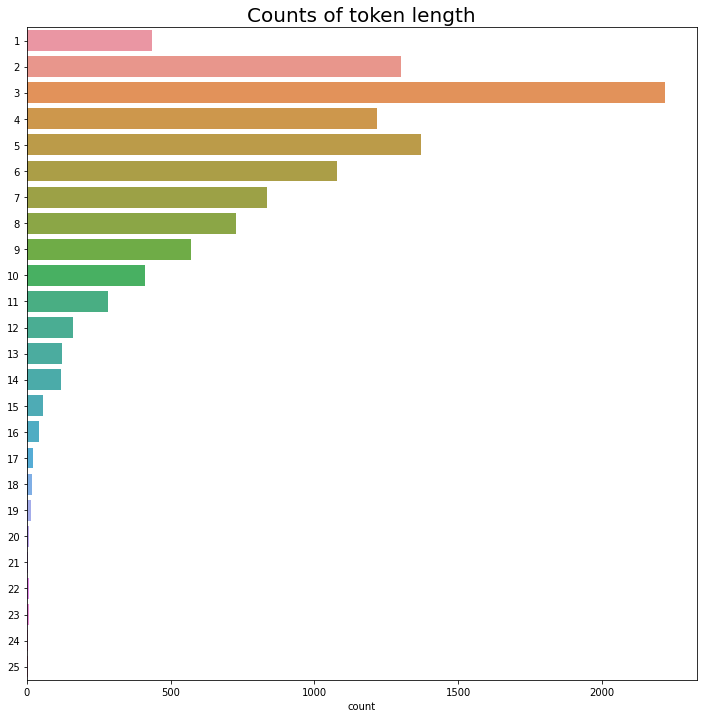

In [ ]:
# Plot distribution
plt.figure(figsize=(12, 12))
sns.countplot(y=token_length)
plt.title("Counts of token length", size=20);

In [ ]:
# Create list of token lengths for each token for the annotated strings
token_length = [len(t) for t in splits_annot]

# Average number of characters per token
print(f"Average number of characters per token: {round(np.mean(token_length),4)}")

Average number of characters per token: 5.0157


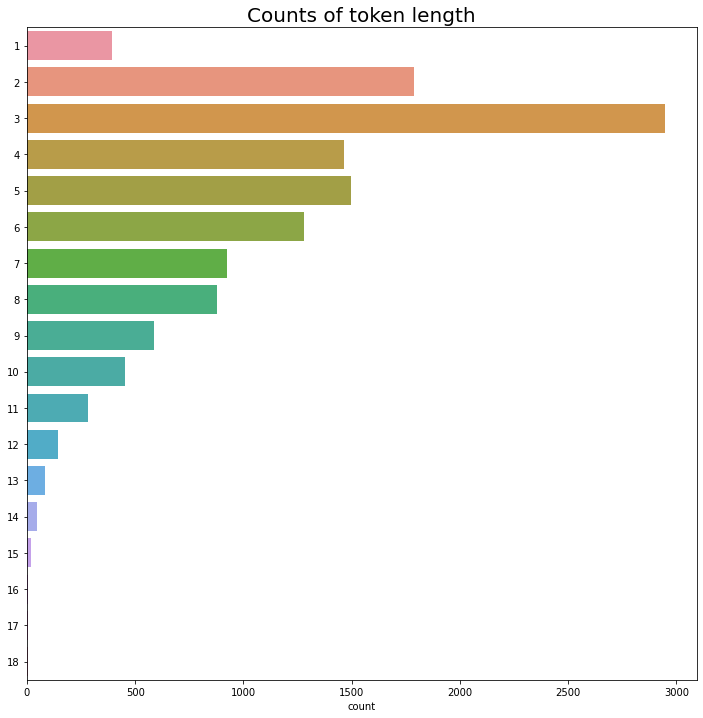

In [ ]:
# Plot distribution for the annotated strings
plt.figure(figsize=(12, 12))
sns.countplot(y=token_length)
plt.title("Counts of token length", size=20);

In [ ]:
import re
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

In [ ]:
def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    # # Tokenise words into alphabetic tokens
    # tokeniser = RegexpTokenizer(r'[A-Za-z]{2,}')
    # tokens = tokeniser.tokenize(text)
    
    # # Lowercase and lemmatise 
    # lemmatiser = WordNetLemmatizer()
    # lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # # Remove stopwords
    # keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    # return keywords
    text_list = text.split() 

    return text_list

def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])

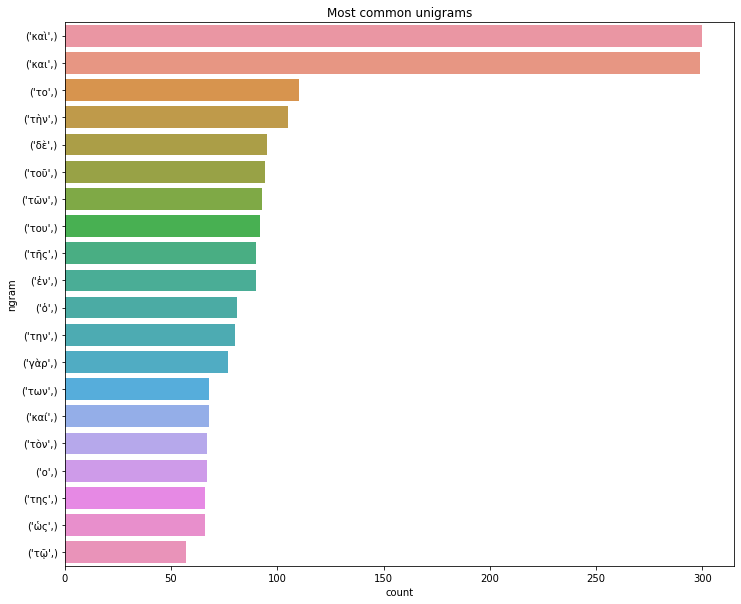

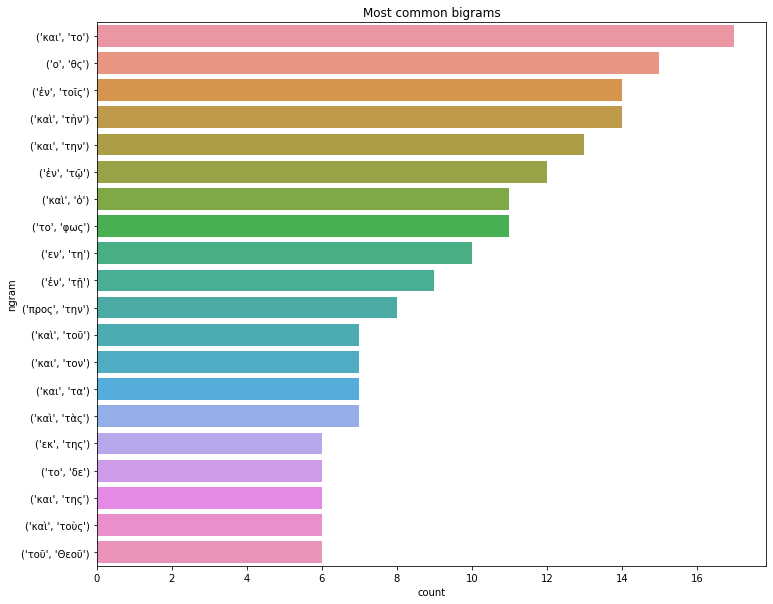

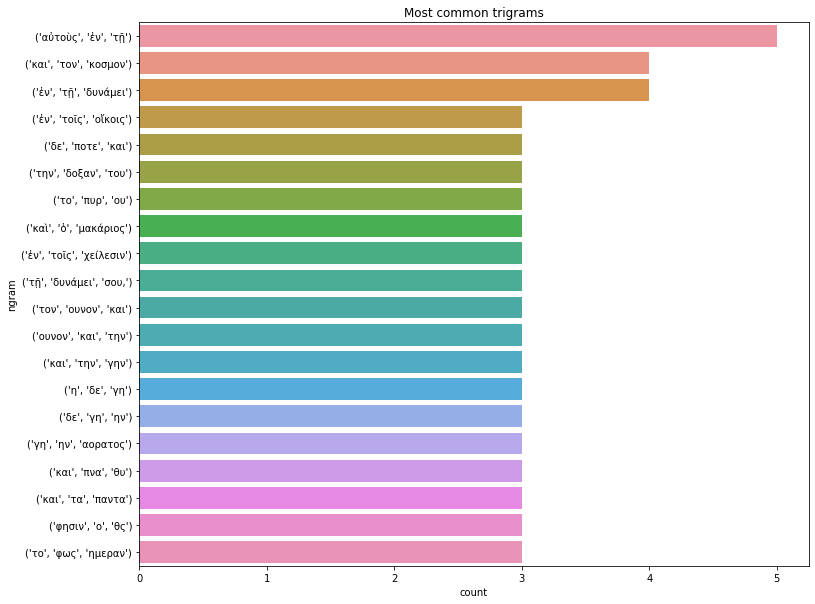

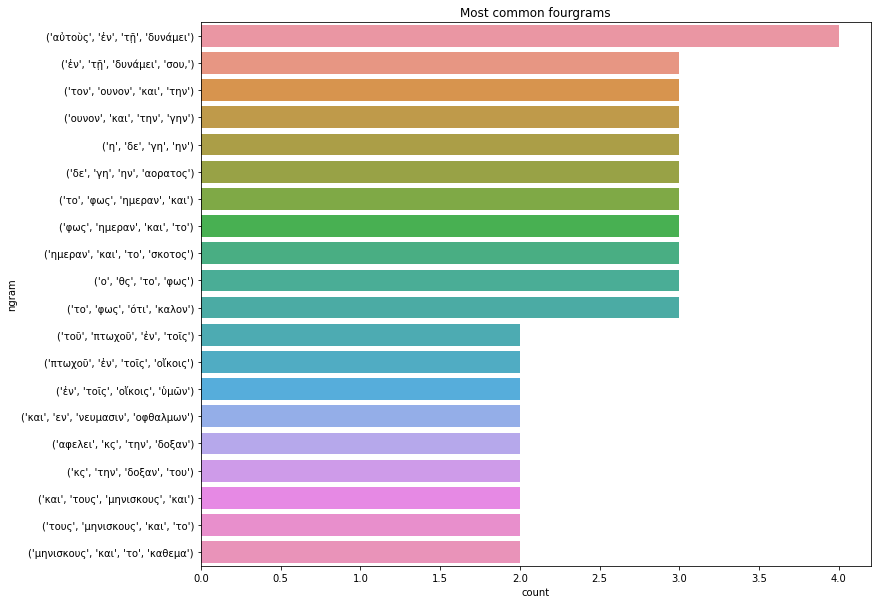

In [ ]:
# Get frequent ngrams for all 4
for i in range(1,5):
    mapping = {1:"uni", 2:"bi", 3:"tri", 4:"four"}
    plt.figure(figsize=(12,10))
    sns.barplot(x="count", y="ngram", data=get_frequent_ngram(train_df.HUMAN_TRANSCRIPTION, i))
    plt.title(f"Most common {mapping[i]}grams");

In [ ]:
def preprocess_text(text):
    """Preprocess text into normalised tokens."""
    text_list = text.split() 

    return text_list

def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [preprocess_text(document) for document in corpus]
    
    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]
    
    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    print(top_freq)
    return pd.DataFrame(top_freq, columns=["ngram", "count"])

In [ ]:
get_frequent_ngram(train_df.HUMAN_TRANSCRIPTION, 4)

[(('αὐτοὺς', 'ἐν', 'τῇ', 'δυνάμει'), 4), (('ἐν', 'τῇ', 'δυνάμει', 'σου,'), 3), (('τον', 'ουνον', 'και', 'την'), 3), (('ουνον', 'και', 'την', 'γην'), 3), (('η', 'δε', 'γη', 'ην'), 3), (('δε', 'γη', 'ην', 'αορατος'), 3), (('το', 'φως', 'ημεραν', 'και'), 3), (('φως', 'ημεραν', 'και', 'το'), 3), (('ημεραν', 'και', 'το', 'σκοτος'), 3), (('ο', 'θς', 'το', 'φως'), 3), (('το', 'φως', 'ότι', 'καλον'), 3), (('τοῦ', 'πτωχοῦ', 'ἐν', 'τοῖς'), 2), (('πτωχοῦ', 'ἐν', 'τοῖς', 'οἴκοις'), 2), (('ἐν', 'τοῖς', 'οἴκοις', 'ὑμῶν'), 2), (('και', 'εν', 'νευμασιν', 'οφθαλμων'), 2), (('αφελει', 'κς', 'την', 'δοξαν'), 2), (('κς', 'την', 'δοξαν', 'του'), 2), (('και', 'τους', 'μηνισκους', 'και'), 2), (('τους', 'μηνισκους', 'και', 'το'), 2), (('μηνισκους', 'και', 'το', 'καθεμα'), 2)]


,ngram,count
0,"(αὐτοὺς, ἐν, τῇ, δυνάμει)",4
1,"(ἐν, τῇ, δυνάμει, σου,)",3
2,"(τον, ουνον, και, την)",3
3,"(ουνον, και, την, γην)",3
4,"(η, δε, γη, ην)",3
5,"(δε, γη, ην, αορατος)",3
6,"(το, φως, ημεραν, και)",3
7,"(φως, ημεραν, και, το)",3
8,"(ημεραν, και, το, σκοτος)",3
9,"(ο, θς, το, φως)",3


In [ ]:
# substring to be searched
sub ='και εν νευμασιν οφθαλμων'
 
# creating and passing series to new column
train_df["Indexes"]= train_df.HUMAN_TRANSCRIPTION.str.find(sub)
 
# display
train_df[train_df["Indexes"]!=-1]

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,Indexes
79,και εν νευμασιν οφθαλμων,καὶεευμαρ ιὁ φθαλαντι,11,3 Bodleian-Library-MS-Barocci-102_00159_fol-76...,20,0
90,προσωπω και εν νευμασιν οφθαλμων το δε υ,"προοπω, και εννευμασιηοφθαλμων το δε",11,4 Bodleian-Library-MS-Barocci-102_00160_fol-76...,2,8


In [ ]:
# substring to be searched
sub ='αὐτοὺς ἐν τῇ δυνάμει'
 
# creating and passing series to new column
train_df["Indexes"]= train_df.HUMAN_TRANSCRIPTION.str.find(sub)
 
# display
train_df[train_df["Indexes"]!=-1]

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,Indexes
1388,Διασκόρπισον αὐτοὺς ἐν τῇ δυνάμει σου· καὶ κατ...,είας κοργιιεοιαὐ τόν ἐητὴ λνναμειςον καὶ καταξ...,12,85 Bodleian-Library-MS-Barocci-132_00243_fol-1...,3,13
1403,"Διασκόρπισον αὐτοὺς ἐν τῇ δυνάμει σου, οὕτως ἔ...","διασκορπισον αὐτοὺς, ἀνα στὰ τῶσον αὐτοὺς τῆ δ...",12,85 Bodleian-Library-MS-Barocci-132_00243_fol-1...,18,13
1458,"δασον αὐτοὺς ἐν τῇ δυνάμει σου, εἰκότως τῇ ταυ...",δασον αὐτοὺς ἐντὴ δνα μείσου εἶκότως τῆ ταὐτολ...,12,86 Bodleian-Library-MS-Barocci-132_00244_fol-1...,35,6


In [ ]:
train_df['HUMAN_TRANSCRIPTION'][1387]

'λογήσεταί σοι; Ποίαν τοίνυν αὐτοὺς βούλειτίσαι ποινήν;'

In [ ]:
train_df['SYSTEM_TRANSCRIPTION'][1387]

'λογησεταισοι ποιαντοῖνν αυτοὺς βου λείτις ποιν ηντ'

In [ ]:
train_df['HUMAN_TRANSCRIPTION'][1388]

'Διασκόρπισον αὐτοὺς ἐν τῇ δυνάμει σου· καὶ κατάγαγε αὐτοὺς,'

In [ ]:
train_df['SYSTEM_TRANSCRIPTION'][1388]

'είας κοργιιεοιαὐ τόν ἐητὴ λνναμειςον καὶ καταξαἝαντοῖς'

In [ ]:
train_df['IMAGE_PATH'][1388]


'85 Bodleian-Library-MS-Barocci-132_00243_fol-115r.jpg'

In [ ]:
train_df['SYSTEM_TRANSCRIPTION'][1403]

'διασκορπισον αὐτοὺς, ἀνα στὰ τῶσον αὐτοὺς τῆ δυναμεῖσ'

In [ ]:
train_df['IMAGE_PATH'][1403]

'85 Bodleian-Library-MS-Barocci-132_00243_fol-115r.jpg'

## Different Vowels

In [ ]:
# substring to be searched
sub ='και'
 
# creating and passing series to new column
train_df["Indexes"]= train_df.HUMAN_TRANSCRIPTION.str.find(sub)
 
# display
train_df[train_df["Indexes"]!=-1]

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,Indexes
7,δικον κτῆσιν και ἀπὸ ἀρπαγῆς καὶ βίας συλλεγόντες,ικον κτῆσιν αποαρπαγης καιβωας συγεγοντεσ,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,8,13
20,μου και το προσωπον των πτωχων καταισχυνετε,"μος, καὶ τοπρο ποτω απτω χω ηκατίςχων ερ",11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,21,4
21,εθος τοις αδικουσι και αποστερουσιν επειδαν,θος τοις ἀδεκου σικαιἀπόστερου σίη επειδαν,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,22,19
22,εγκαλωνται παρα των ηδικημενων υβρεσι και λοι,ἐγκαλων τα παρατων ηδικήμενων χβρεσικατ,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,23,38
23,δοριαις καταισχυνειν αυτους εξευτελιζοντες και,δορίαι εκαται εχν εν αυτοὺς ἐξευὑτελύζον τεσκαι,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,24,43
...,...,...,...,...,...,...
1869,θς ων την ημετεραν υπεδυ σαρκα και δια την,θε ων την ημετεραν υθυθυ σαρκα ῷδια την,10,100 Bodleian-Library-MS-Barocci-184_00040_fol-...,24,31
1870,σριαν του των ανων γενους γεγονε ανος και τι λε,σριαν τουτων ανων γενθυγεγονενανος ότιμε,10,100 Bodleian-Library-MS-Barocci-184_00040_fol-...,25,38
1871,γω την ημετεραν υπεδυ σαρκα και τ αλλα παν,γω την η μετεραν υπεθσαρκα ειταλλαπαν,10,100 Bodleian-Library-MS-Barocci-184_00040_fol-...,26,28
1872,τα ανινα υπεμεινεν οπου γε και τον στρον κατε,τα ανινα υπεμειμεν οπουγεκαι ετριν κατε,10,100 Bodleian-Library-MS-Barocci-184_00040_fol-...,27,27


In [ ]:
id = 20

print(train_df['HUMAN_TRANSCRIPTION'][id])
print(train_df['SYSTEM_TRANSCRIPTION'][id])
print(train_df['IMAGE_PATH'][id])
print(train_df['TEXT_LINE_NUM'][id])

μου και το προσωπον των πτωχων καταισχυνετε
μος, καὶ τοπρο ποτω απτω χω ηκατίςχων ερ
1 Bodleian-Library-MS-Barocci-102_00157_fol-75r.jpg
21


In [ ]:
# substring to be searched
sub ='καὶ'
 
# creating and passing series to new column
train_df["Indexes"]= train_df.HUMAN_TRANSCRIPTION.str.find(sub)
 
# display
train_df[train_df["Indexes"]!=-1]

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,Indexes
2,τες ἐμπυρίζουσι τὸν ἀμπελῶνα ἀλλὰ καὶ ὁ διὰ,τες εμπυριζου σιμαμπελῶνα ἀλλακαι ὅδξα,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,3,34
5,ζει τὸν ἀμπελῶνα επισυνάπτει γοῦν τό καὶ ἡ ἀρπα,λει τον αμπέλῶνα συναπτειγὰρ τοκαι καρπα,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,6,37
6,γὴ τοῦ πτωχοῦ ἐν τοῖς οἴκοις ὑμῶν ὥστε καὶ ἄ,"γη του πτωχουεντοις οικοιςχμῶν, ωστεκακα",11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,7,39
7,δικον κτῆσιν και ἀπὸ ἀρπαγῆς καὶ βίας συλλεγόντες,ικον κτῆσιν αποαρπαγης καιβωας συγεγοντεσ,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,8,29
10,εστῶτας καὶ τοῦ λαοῦ παντὸς εἰς τὴν κατ ΄ ἀλλή,ετώτας καὶ του λαουπαντος εις την καταλλης,11,1 Bodleian-Library-MS-Barocci-102_00157_fol-75...,11,8
...,...,...,...,...,...,...
1601,"βόλους, ἰδεῖν αὐτὴν ὁ προφήτης τετειχισμένην π...",βολους ιδεῖναὐ τὴν ὁ προφητης τετείχις μεν ην ...,12,90 Bodleian-Library-MS-Barocci-132_00248_fol-1...,26,52
1602,"ἕως της Ἰδουμαίας ὡς βασιλεὺς δραμεῖν, καὶ ἰδ...","ξωστῆς ιδουμαίας, ως βασιλευων δραμεῖν καιιδεῖ...",12,90 Bodleian-Library-MS-Barocci-132_00248_fol-1...,27,40
1604,"σον, Κε, ὁ ἀπωσάμενος ἡμᾶς, καὶ τῇ τῶν Βαβυλων...",σονκε οα πωσαμενος ἡμας υκαὶ τὴ τῶν βα βνλῶν ι...,12,90 Bodleian-Library-MS-Barocci-132_00248_fol-1...,29,28
1608,"καὶ οὐ στρατηγεῖς, οὐδὲ ἀριστεύεις συνήθως. Δὸ...",και ουστρα τῆγεῖς οὐ δὲ αριστευεις συνηθως ς ἀ...,12,90 Bodleian-Library-MS-Barocci-132_00248_fol-1...,33,0


#### Frequently mistaken tokens 

In [ ]:
LEX = train_df.HUMAN_TRANSCRIPTION.sum().split()

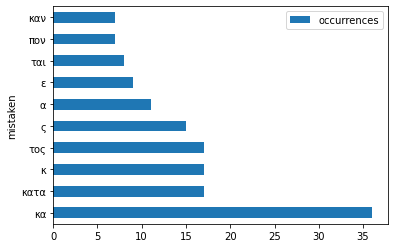

In [ ]:
from collections import Counter
broken_words = [w for w in train_df.SYSTEM_TRANSCRIPTION.sum().split() if w not in set(LEX)]
x,y = zip(*Counter(broken_words).most_common(10))
pd.DataFrame({"mistaken":x, "occurrences":y}).plot.barh(x="mistaken");

In [ ]:
pd.DataFrame({"mistaken":x, "occurrences":y}).to_csv('mistake.csv')

Picking one, one that can be fixed without much ambiguity.

In [ ]:
train_df[train_df.SYSTEM_TRANSCRIPTION.str.contains(" ς ")].sample(2)

,HUMAN_TRANSCRIPTION,SYSTEM_TRANSCRIPTION,CENTURY,IMAGE_PATH,TEXT_LINE_NUM,Indexes
81,μα περιεργα βλεπειν τω οφθαλμω την α,μα περιεργα βλεπσει μτω ς φθαλμω τὴν ἀ,11,3 Bodleian-Library-MS-Barocci-102_00159_fol-76...,22,-1
1509,"μάτων ἐσομένων ἀνθρώπων. Ὁ Θς, ἀπώσω ἡμᾶς, κα...",μα τῶν ομενῶνανωντ Ὁθεατίω ς νήμας και καθεί,12,88 Bodleian-Library-MS-Barocci-132_00246_fol-1...,10,44
